### Assignment 4 Generative Adversarial Nets (Unconditional, 10pt)


In this exercise, we will implement a Generative Adversarial Net (GAN), specifically, a Wasserstein GAN and train it on the MNIST dataset. *We recommend completing this assignment using Google Colab with Chrome Browser*.

**Submit**
1. (<font color='red'>Doc A</font>) Figures and numerical results required in the following questions (include them in the pdf generated by latex file with Exercise 2)
2. (<font color='red'>Doc B</font>) The completed *.ipynb file with all the command outputs (can be created by saving the file after finishing the experiment and downloading it from Colab)
3. (<font color='red'>Doc C</font>) The PDF version of the saved *.ipynb file (can be created by printing it as a PDF file in Chrome)

## Setup


1. In Colab, open tab Runtime > Change runtime type, choose *python3* and *T4 GPU*.
2. Run the following command to set up the environment. (Takes ~ 1.5 min)



In [3]:
! pip install --quiet "ipython[notebook]==7.34.0, <8.17.0" "setuptools>=68.0.0, <68.3.0"  "torch==1.13.0" "matplotlib"  "torchvision" 

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/4UyBxlJChfc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Let's start with importing our standard set of libraries.

In [1]:
import torch
from torch import nn, optim, autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import sys
%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 2 epoch is sufficient to get full mark. (NOTE THAT 2 epochs takes approximately 1.5 hours to train for CPU)
  print('GPU is not detected. Make sure you have chosen the right runtime type')

Everything looks good; continue


## Dataloaders and hyperparameters (0 pt)

In [3]:
@dataclass
class Hyperparameter:
    batchsize: int          = 64
    num_epochs: int         = 5
    latent_size: int        = 32
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
        
hp = Hyperparameter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                                
dataset  = torchvision.datasets.MNIST("mnist", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, num_workers=1,
                                         shuffle=True, drop_last=True, pin_memory=True)

## Building Models  (2 pts)

After examining the preprocessing steps, we can now start building the models, including the generator for generating new images from random noise, and a critic of the realness of the image.


In this assignment we adopt the implementation of [DCGAN](https://arxiv.org/pdf/1511.06434), which is a direct extension of [GAN](https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), with convolutional and convolutional-transpose layers in the critic and genrator, respectively. Specifically, we will use the [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layers to upscale the noise.

Moreover, we apply an improved version of [Wasserstein-GAN](https://arxiv.org/pdf/1701.07875) with a [Gradient Penalty](https://arxiv.org/pdf/1704.00028) (you may read Algorithm 1 to fully understand the code we are implementing). 


In [4]:
# Define the generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Add latent embedding layer to adjust the dimension of the input (1 pt)

        self.latent_embedding = nn.Sequential(
            nn.Linear(hp.latent_size, hp.generator_size),
        )

        # Hint: you should use the hyperparameters defined above
        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        
        
        # Transposed CNN layers to transfer noise to image 
        
        self.tcnn = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size, 4, 1, 0),
        nn.BatchNorm2d(hp.generator_size),
        nn.ReLU(inplace=True),
        # upscaling
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size // 2, 3, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 2),
        nn.ReLU(inplace=True),
        # upscaling
        nn.ConvTranspose2d(hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(hp.generator_size // 4, 1, 4, 2, 1),
        nn.Tanh()
        )
        
        
    def forward(self, latent):
        vec_latent = self.latent_embedding(latent).reshape(-1, hp.generator_size, 1, 1)
        return self.tcnn(vec_latent)

    
# Define the critic

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        # CNN layers that perform downscaling
        self.cnn_net = nn.Sequential(
        nn.Conv2d(1, hp.critic_size // 4, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
        nn.InstanceNorm2d(hp.critic_size, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        )
        
        # Linear layers that produce the output from the features
        self.critic_net = nn.Sequential(
        nn.Linear(hp.critic_size * 4, hp.critic_hidden_size),
        nn.LeakyReLU(0.2, inplace=True), 
        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Add the last layer to reflect the output (1 pt)
        
        nn.Linear(hp.critic_hidden_size, 1),

        # Hint: Given an image, the output of the critic is a value (or a scalar)
        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        )
    
    def forward(self, image):
        cnn_features = self.cnn_net(image)
        return self.critic_net(cnn_features)


## Before Training 

Next we fine the two models and the optimizers. We use [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) algorithm.



In [5]:
critic, generator = Critic().to(device), Generator().to(device)

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4,betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4,betas=(0., 0.9))

## Training pipeline (6 points)


Finally, we perform training on the two networks. The training consists of two steps: (1) Updating discriminators for n_critic steps (such that we have an optimal critic): here we use an aggregation of three loss functions, (a) The real loss (the output scalar of the critic for real images); (b) The fake loss (same value for fake images); (c) The [gradient penalty](https://arxiv.org/pdf/1704.00028). (2) Updating generators by only considering the fake loss (to fool the critic).


In [7]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
fixed_noise = torch.randn((64, hp.latent_size), device=device)
grad_tensor = torch.ones((hp.batchsize, 1), device=device)
start_time = time.time()
for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        
        # Update Critic
        critic_optimizer.zero_grad()
        
        # (a) Real loss
        critic_output_real = critic(real_images)
        critic_loss_real = critic_output_real.mean()
        
        # (b) Fake loss
        
        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Implement the fake loss 
        
        # (1) Generating a loss tensor (of dimension (batch_size, latent_size)), you are required to 
        # use the hyperparameters in the hp class (0.5 pt)
        noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
        
        # (2) Generate fake images using the generator (hint: you are not supposed to perform gradient
        # update on the generator) (1.5 pt)
        with torch.no_grad(): 
            fake_image = generator(noise)
        
        # (3) Calculate the fake loss using the output of the generator (1 pt)
        critic_output_fake = critic(fake_image)
        critic_loss_fake = critic_output_fake.mean()

        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        
        #  (c) Gradient penalty
        alpha = torch.rand((hp.batchsize, 1, 1, 1), device=device)
        interpolates = (alpha * real_images + ((1. - alpha) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()

        #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
        # Implement the aggregated loss using the above three components, be careful with the signs (1 pt)
        
        critic_loss = -critic_loss_real + critic_loss_fake  + gradient_penalty
        
        # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
        
        
        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            
            
            #VVVVVVVVVVV TO BE COMPLETE (START) VVVVVVVVVVVV
            # Implement the generator loss (2 pt)
            
            noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
            fake_image = generator(noise)
            critic_output_fake = critic(fake_image)
            generator_loss = -critic_output_fake.mean()

            # ^^^^^^^^^^^^ TO BE COMPLETE (END) ^^^^^^^^^^^^
            
            generator_loss.backward()
            generator_optimizer.step()
        
        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")
       
        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad(): fake_images = generator(fixed_noise).cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
        iters += 1

[ 0/5][      0][    1.12s]	d_loss/g_loss:  2.0/0.17	
[ 0/5][    100][    4.46s]	d_loss/g_loss: -4.9/0.56	
[ 0/5][    200][    8.06s]	d_loss/g_loss: -3.3/-0.57	
[ 0/5][    300][   11.78s]	d_loss/g_loss: -3.2/0.47	
[ 0/5][    400][   15.27s]	d_loss/g_loss: -4.4/-0.14	
[ 0/5][    500][   18.92s]	d_loss/g_loss: -5.1/0.58	
[ 0/5][    600][   22.45s]	d_loss/g_loss: -4.9/0.72	
[ 0/5][    700][   26.06s]	d_loss/g_loss: -4.9/ 1.4	
[ 0/5][    800][   29.47s]	d_loss/g_loss: -4.4/0.87	
[ 0/5][    900][   33.00s]	d_loss/g_loss: -4.5/0.55	
[ 1/5][    937][   34.41s]	d_loss/g_loss: -4.5/ 1.1	
[ 1/5][   1037][   37.99s]	d_loss/g_loss: -5.0/ 2.4	
[ 1/5][   1137][   41.49s]	d_loss/g_loss: -5.2/ 1.3	
[ 1/5][   1237][   45.10s]	d_loss/g_loss: -1.7/-1.3	
[ 1/5][   1337][   48.67s]	d_loss/g_loss: -1.9/-1.2	
[ 1/5][   1437][   52.26s]	d_loss/g_loss: -1.3/0.83	
[ 1/5][   1537][   55.82s]	d_loss/g_loss: -1.5/-0.37	
[ 1/5][   1637][   59.47s]	d_loss/g_loss: -1.1/0.0016	
[ 1/5][   1737][   63.13s]	d_loss/g_loss:

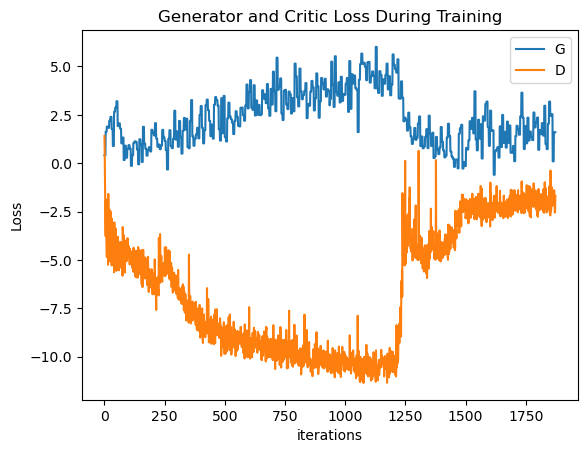

In [38]:
# Visualize the loss

plt.title("Generator and Critic Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

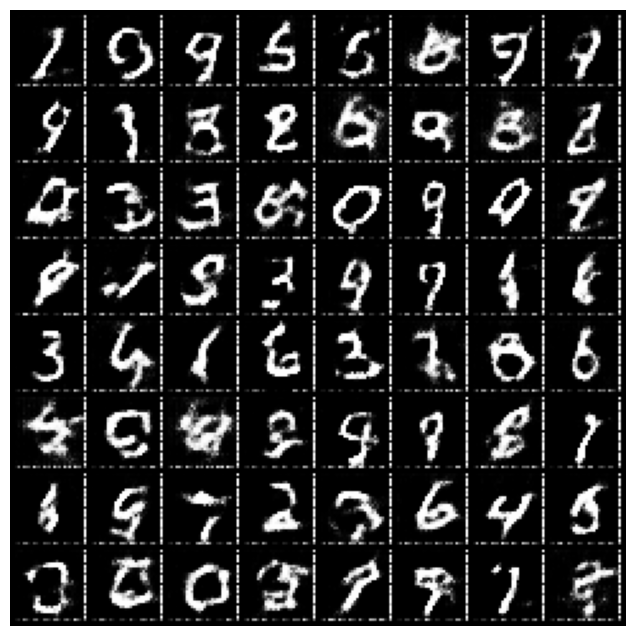

In [43]:
# visualize the generation (you may scroll to see the animation of training)

import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())